Algoritmo de Grover

Considere utilizar um ambiente virtual venv ou conda para executar seu código.

Este código de exemplo foi preparado usando Python 3.11 e as dependências estão no arquivo requirements.txt, e podem ser instaladas com o comando a seguir:

'''python install -r requirements.txt'''



Para executar o algoritmo de Grover usando a classe Grover, primeiramente, precisamos especificar um oráculo para o circuito do algoritmo de Grover. No exemplo a seguir, usamos o QuantumCircuit como o oráculo do algoritmo de Grover. No entanto, há várias outras classes que podemos usar como o oráculo do algoritmo de Grover. Falaremos sobre elas mais adiante.

Observe que o oráculo para Grover deve ser um oráculo de inversão de fase. Ou seja, ele multiplica os amplitudes dos "estados bons" por um fator de -1. Explicaremos mais adiante como converter um oráculo de inversão de bits em um oráculo de inversão de fase.

In [1]:
from qiskit import Aer
from qiskit import QuantumCircuit
from qiskit.algorithms import AmplificationProblem

# Ferramentas para visualização
from qiskit.visualization import plot_histogram, plot_state_qsphere

1. Crie um oráculo

Para iniciar, vamos considerar um cenário em que buscamos o estado '11'.
No bloco a seguir, defina o oráculo que marca este estado como uma boa solução.

In [2]:
# Estado desejado, que se quer encontrar
estado_desejado = ['11']

# Defina o oráculo que marca o estado '11' como solução
oraculo = QuantumCircuit(2)
oraculo.cz(0,1)


Teste a marcação feita pelo seu oráculo

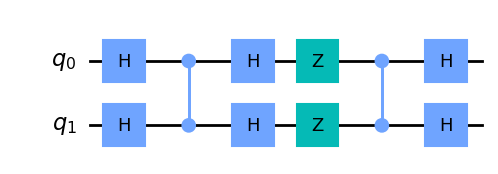

In [3]:

teste_oraculo = QuantumCircuit(2)
teste_oraculo.h([0,1])
teste_oraculo.compose(oraculo, inplace=True)
teste_oraculo.h([0,1])
teste_oraculo.z([0,1])
teste_oraculo.compose(oraculo, inplace=True)
teste_oraculo.h([0,1])
teste_oraculo.draw('mpl')


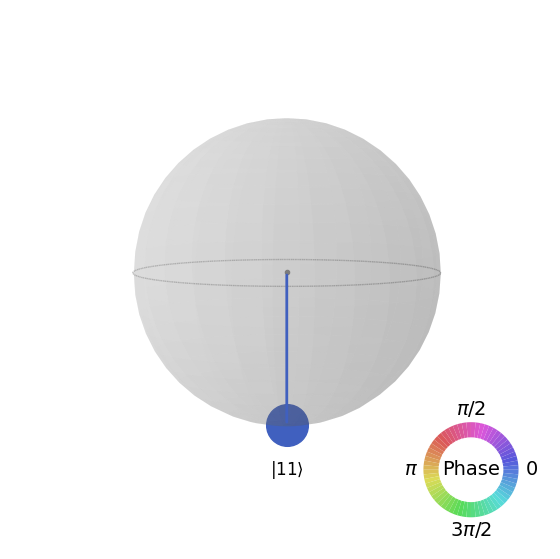

In [4]:
plot_state_qsphere(teste_oraculo)

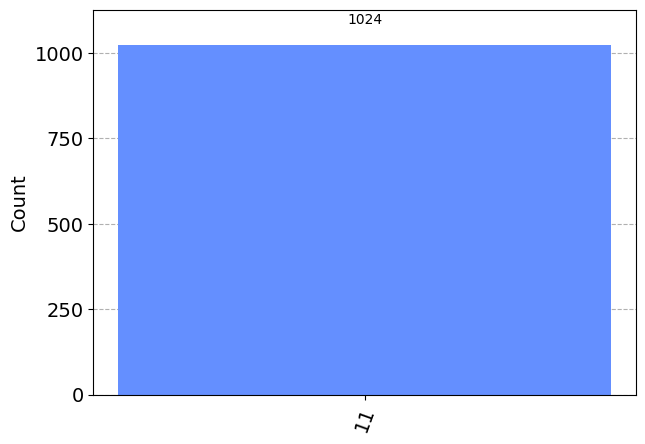

In [5]:
teste_oraculo.measure_all()

simulador = Aer.get_backend('qasm_simulator')
resultado_simulador = simulador.run(teste_oraculo).result()
quantidade = resultado_simulador.get_counts()
plot_histogram(quantidade)

Retornando à implementação de Grover

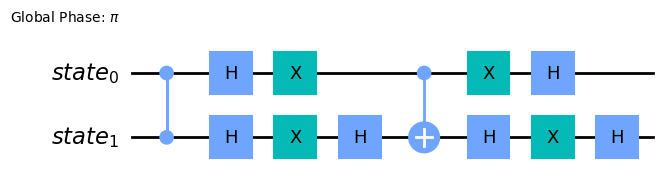

In [6]:
problema = AmplificationProblem(oraculo, is_good_state=estado_desejado)

# Circuitos de algoritmo são exibidos como uma única caixa,
# por isso é necessário executar o .decompose() para de uma
# forma expandida os gates que o compoem
problema.grover_operator.decompose().draw(output='mpl')


In [7]:
from qiskit.algorithms import Grover
from qiskit.primitives import Sampler

grover = Grover(sampler=Sampler())
resultado = grover.amplify(problema)

print('Tipo de resultado:', type(resultado))
print()
print('Sucesso!' if resultado.oracle_evaluation else 'Falha!')
print('Principal medida:', resultado.top_measurement)

Tipo de resultado: <class 'qiskit.algorithms.amplitude_amplifiers.grover.GroverResult'>

Sucesso!
Principal medida: 11


Até agora usamos o QuantumCircuit como o oráculo. No entanto, também podemos usar qiskit.quantum_info.Statevector para criar o oráculo. Os exemplos a seguir consideram que '11' é um "estado bom".

In [8]:
from qiskit.quantum_info import Statevector
oracle = Statevector.from_label('01')
problem = AmplificationProblem(oracle, is_good_state=['01'])

grover = Grover(sampler=Sampler())
result = grover.amplify(problem)

print('Tipo de resultado:', type(resultado))
print()
print('Sucesso!' if resultado.oracle_evaluation else 'Falha!')
print('Principal medida:', resultado.top_measurement)

Tipo de resultado: <class 'qiskit.algorithms.amplitude_amplifiers.grover.GroverResult'>

Sucesso!
Principal medida: 11


Outra maneira de criar oráculos é através de expressões lógicas, como 'a | b'. A seguir, usaremos essa técnica para criar o equivalente ao '11':

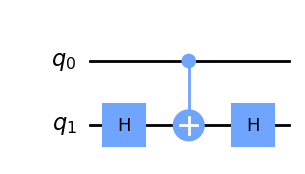

In [9]:
from qiskit.circuit.library.phase_oracle import PhaseOracle
from qiskit.exceptions import MissingOptionalLibraryError


expressao = '(a & b)'

try:
    oracle = PhaseOracle(expressao)
    problem = AmplificationProblem(oracle, is_good_state=oracle.evaluate_bitstring)
    display(problem.grover_operator.oracle.decompose().draw(output='mpl'))
except MissingOptionalLibraryError as ex:
    print(ex)


Para um problema real:

https://www.infoteca.cnptia.embrapa.br/infoteca/bitstream/doc/976493/1/CATALOGOSojaCentrosul2013.pdf

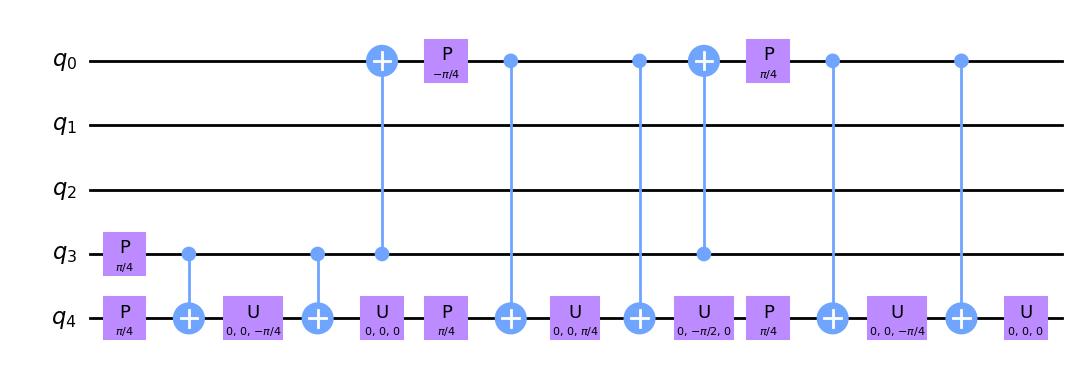

In [15]:
from qiskit.circuit.library.phase_oracle import PhaseOracle
from qiskit.exceptions import MissingOptionalLibraryError


expressao = '(a | b | c | d | e ) & (a & d & e)'

try:
    oracle = PhaseOracle(expressao)
    problem = AmplificationProblem(oracle, is_good_state=oracle.evaluate_bitstring)
    display(problem.grover_operator.oracle.decompose().draw(output='mpl'))
except MissingOptionalLibraryError as ex:
    print(ex)


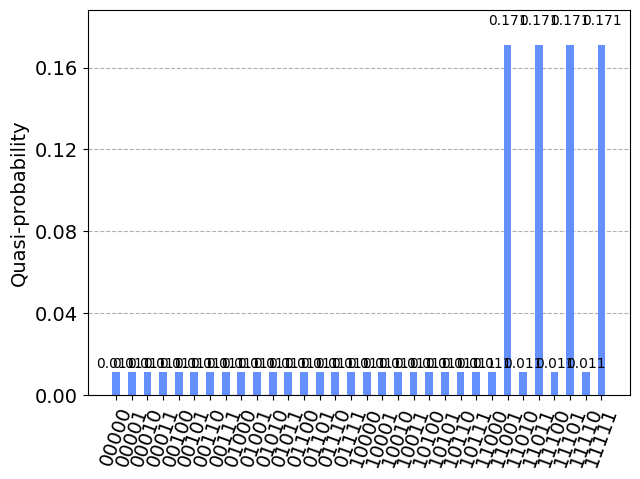

In [11]:
grover = Grover(sampler=Sampler(), iterations=1024)
result = grover.amplify(problem)
display(plot_histogram(result.circuit_results[0]))

Executar em um computador Quântico Real


https://github.com/Qiskit/qiskit-ibm-runtime#account-setup

export QISKIT_IBM_TOKEN="MY_IBM_CLOUD_API_KEY"
export QISKIT_IBM_INSTANCE="MY_IBM_CLOUD_CRN"
export QISKIT_IBM_CHANNEL="ibm_cloud"


from qiskit_ibm_runtime import QiskitRuntimeService

# Save an IBM Cloud account.
QiskitRuntimeService.save_account(channel="ibm_cloud", token="MY_IBM_CLOUD_API_KEY", instance="MY_IBM_CLOUD_CRN")

# Save an IBM Quantum account.
QiskitRuntimeService.save_account(channel="ibm_quantum", token="MY_IBM_QUANTUM_TOKEN")




https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials/grover_with_sampler.html



In [29]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Options, Sampler

service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q/open/main',
)

#backend = "ibmq_qasm_simulator"  # use the simulator
backend = "ibmq_belem"  # use 5q 


options = Options(optimization_level=3)
options.execution.shots = 1024  # Options can be set using auto-complete.


In [32]:
expressao = '(a | b | c | d | e ) & (a & d & e)'

try:
    oracle = PhaseOracle(expressao)
    problem = AmplificationProblem(oracle, is_good_state=oracle.evaluate_bitstring)


    # TODO more interactions?
    grover = Grover(iterations=1)
    circuit = grover.construct_circuit(problem)
    circuit.measure_all()


    with Session(service=service, backend=backend):
        sampler = Sampler()
        job = sampler.run(circuits=circuit, shots=1000)
        result = job.result()
        print(result)

except MissingOptionalLibraryError as ex:
    print(ex)

runtime_job._start_websocket_client:WARNING:2023-05-21 18:44:04,992: An error occurred while streaming results from the server for job chl8u7lnopt07g3d6c00:
Traceback (most recent call last):
  File "/home/wsluser/miniconda3/envs/QiskitNotebook/lib/python3.10/site-packages/qiskit_ibm_runtime/runtime_job.py", line 505, in _start_websocket_client
    self._ws_client.job_results()
  File "/home/wsluser/miniconda3/envs/QiskitNotebook/lib/python3.10/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/home/wsluser/miniconda3/envs/QiskitNotebook/lib/python3.10/site-packages/qiskit_ibm_runtime/api/clients/base.py", line 230, in stream
    raise WebsocketError(error_message)
qiskit_ibm_runtime.api.exceptions.WebsocketError: 'Max retries exceeded: Failed to establish a websocket connection.'



SamplerResult(quasi_dists=[{0: 0.01620954170479937, 1: 0.01619931159284575, 2: 0.01768151819151898, 3: 0.022074196149597207, 4: 0.03248500837112013, 5: 0.025670297773015237, 6: 0.023869911105256835, 7: 0.023538623613743637, 8: 0.016315111133949508, 9: 0.01736864670289378, 10: 0.03098158227970901, 11: 0.026580859414689576, 12: 0.028986096860548868, 13: 0.026021573019954114, 14: 0.015081954393017035, 15: 0.02867495371507543, 16: 0.027867556206761866, 17: 0.024128224953037587, 18: 0.02674484859991231, 19: 0.030452446786610788, 20: 0.04102036921076035, 21: 0.03285359739454623, 22: 0.02920799795587997, 23: 0.021574562324070963, 24: 0.033654700126515696, 25: 0.05630744123084903, 26: 0.026071859501914138, 27: 0.076383976277353, 28: 0.0427474941994291, 29: 0.04651188602467709, 30: 0.04549228314482596, 31: 0.07124157004112142}], metadata=[{'shots': 1000, 'readout_mitigation_overhead': 2.9467482097925464, 'readout_mitigation_time': 0.054471271112561226}])


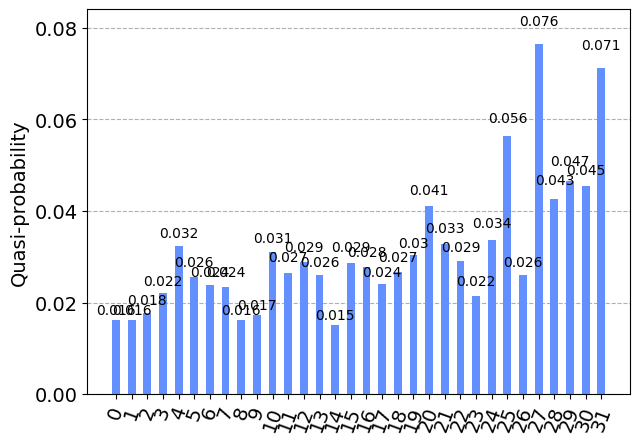

In [33]:
plot_histogram(result.quasi_dists)